## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [0]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

# 暫存
model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)


In [10]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
__________

In [11]:
# Collect results
exp_name_tag = ("exp-ModelCheckPoint")
results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                         'valid-loss': model.history.history["val_loss"],
                         'train-acc': model.history.history["acc"],
                         'valid-acc': model.history.history["val_acc"]}

print('*'*80)
# 儲存模型
model.save("final_model.h5")
print('save model to file: final_model.h5 ...DONE')
model.save_weights("model_weights.h5")
print('save model weights to file: model_weights.h5 ...DONE')

pred_final = model.predict(x_test)
print('before save model: predict=', pred_final)
print('-'*80)

# Load back
model = keras.models.load_model("./tmp.h5")
pred_loadback = model.predict(x_test)
print('after model(tmp.h5) reload: predict=', pred_loadback)
print('*'*80)

********************************************************************************
save model to file: final_model.h5 ...DONE
save model weights to file: model_weights.h5 ...DONE
before save model: predict= [[2.2436264e-03 1.8946698e-02 2.8936265e-03 ... 1.0230487e-05
  1.6884202e-01 1.6125858e-02]
 [8.2471957e-03 4.0737245e-02 2.4197008e-05 ... 1.0896570e-05
  8.3750695e-01 1.1298179e-01]
 [6.8692714e-01 3.6214173e-02 8.7514361e-03 ... 2.4370675e-03
  2.0820813e-01 5.2738633e-02]
 ...
 [8.3658466e-05 4.5714535e-07 7.8761613e-01 ... 2.5897014e-03
  1.6181212e-03 4.8954890e-04]
 [8.8302582e-04 8.3608348e-03 5.6436360e-03 ... 7.7417423e-03
  5.1654454e-02 2.6335730e-04]
 [1.9797503e-03 1.6328703e-04 4.3419570e-02 ... 1.7702416e-02
  2.1489053e-04 2.1693965e-03]]
--------------------------------------------------------------------------------
after model(tmp.h5) reload: predict= [[1.3962052e-03 2.2590163e-03 2.3056531e-02 ... 5.6851219e-04
  4.4136271e-03 5.0592615e-04]
 [1.9369191e-02 1.40

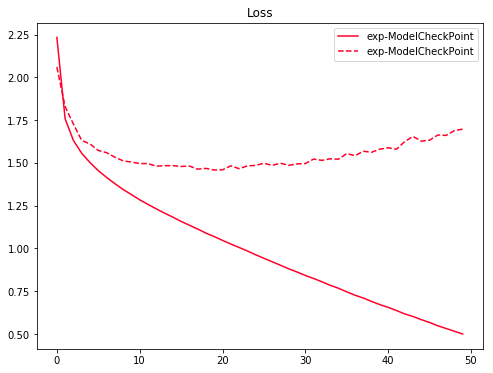

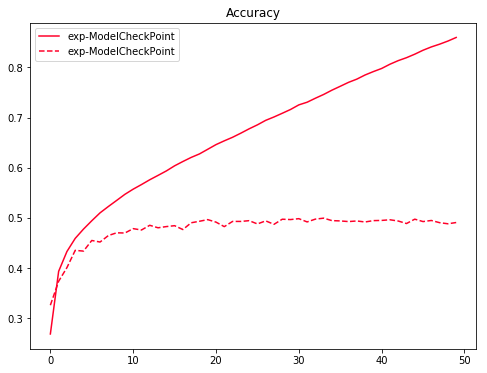

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors

"""Code Here
將結果繪出
"""

NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score

final_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_final.argmax(axis=-1))
loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_loadback.argmax(axis=-1))

print("Accuracy of final weights: %.3f" % final_model_acc)
print("Accuracy of best weights: %.3f" % loadback_acc)

Accuracy of final weights: 0.491
Accuracy of best weights: 0.497


In [14]:
new_model = build_mlp(input_shape=x_train.shape[1:])
new_model_pred = new_model.predict(x_test)
new_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of best weights: %.3f" % new_model_acc)

new_model.load_weights("./model_weights.h5")
new_model_pred = new_model.predict(x_test)
new_model_loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of best weights: %.3f" % new_model_loadback_acc)

Accuracy of best weights: 0.100
Accuracy of best weights: 0.491
